In [12]:
import numpy as np 
import pandas as pd 
import os

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix



In [15]:
hepatitis_data = pd.read_csv("C:/Pooja/PDL/hepatitis_1.csv")

In [16]:
replacements = {'no': 0,
               'yes': 1,
               'DIE': 0,
               'LIVE': 1,
               '?': np.nan,
               'female': 0,
               'male': 1}

hepatitis_data.replace(replacements, inplace = True)
hepatitis_data = hepatitis_data.astype(float)
hepatitis_data[['ALBUMIN', 'ALK_PHOSPHATE', 'BILIRUBIN', 'SGOT']] = hepatitis_data[['ALBUMIN','ALK_PHOSPHATE', 'BILIRUBIN', 'SGOT']].applymap(np.log)

In [17]:
hepatitis_data.isnull().sum()


AGE                 0
SEX                 0
STEROID             1
ANTIVIRALS          0
FATIGUE             1
MALAISE             1
ANOREXIA            1
LIVER_BIG          10
LIVER_FIRM         11
SPLEEN_PALPABLE     5
SPIDERS             5
ASCITES             5
VARICES             5
BILIRUBIN           6
ALK_PHOSPHATE      29
SGOT                4
ALBUMIN            16
PROTIME            67
HISTOLOGY           0
Class               0
dtype: int64

In [18]:
x = hepatitis_data.iloc[:, hepatitis_data.columns != 'Class']
y = hepatitis_data.iloc[:, hepatitis_data.columns == 'Class']

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [20]:
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

In [13]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)

fit_random_forest = RandomForestClassifier(random_state = 42)

fit_random_forest.fit(X_train_imp, Y_train);

In [23]:
X_test_imp = imp.transform(X_test)

y_predicted = fit_random_forest.predict(X_test_imp)

In [24]:
accuracy = accuracy_score(Y_test, y_predicted)*100
print(round(accuracy, 2), '%')


70.97 %


In [25]:
#Hyperparameter tuning
parameters_optimize = {
                      'max_features': ['auto', 'sqrt', 'log2', None], 
                      'max_depth': [2,3, 4],
                      'criterion': ['gini', 'entropy'],
                      'bootstrap': [True, False],
                      'n_estimators': [2, 5, 10, 15, 20]
                      }

In [26]:
random_forest_hyp = RandomForestClassifier()

random_forest_search = GridSearchCV(random_forest_hyp,
                                   cv = 20,
                                   param_grid = parameters_optimize,
                                   n_jobs = 3)
random_forest_search.fit(X_train_imp, Y_train);

In [27]:
print('The best parameteres after GridSearchCV', random_forest_search.best_params_)

The best parameteres after GridSearchCV {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 15}


In [28]:
random_forest_hyp.set_params(bootstrap = True, 
                            criterion = 'gini',
                            max_depth = 4,
                            max_features = 'auto',
                            n_estimators = 20);

In [29]:
random_forest_hyp.fit(X_train_imp, Y_train);

In [30]:
y_predicted_grid = random_forest_hyp.predict(X_test_imp)

In [31]:
accuracy_grid = accuracy_score(Y_test, y_predicted_grid)*100
print(round(accuracy_grid, 2), '%')

80.65 %


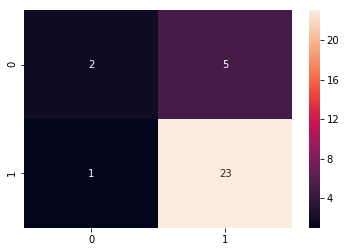

In [32]:
plt.figure()
random_confusion = confusion_matrix(Y_test, y_predicted_grid)
sns.heatmap(random_confusion, annot = True);

In [33]:
fpr, tpr, _= roc_curve(Y_test, y_predicted_grid)

In [34]:
auc_random_grid = auc(fpr, tpr)
print(auc_random_grid)

0.6220238095238095


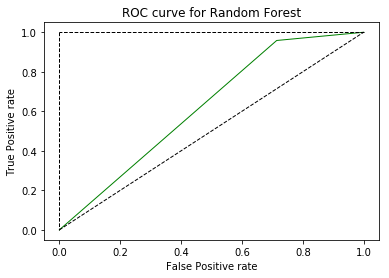

In [35]:
plt.figure()
plt.plot(fpr, tpr, color ='Green', linewidth = 1)
plt.title('ROC curve for Random Forest')
plt.plot([0,1], [0,1], 'k--', lw = 1)
plt.plot([0,0], [1,0], 'k--', lw = 1, color = 'black')
plt.plot([1,0], [1,1], 'k--', lw = 1, color = 'black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate');

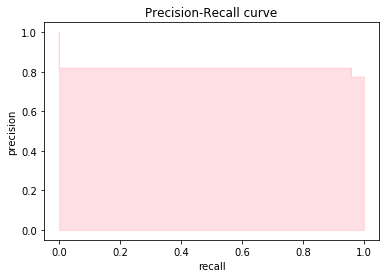

In [36]:
precision, recall, _ = precision_recall_curve(Y_test, y_predicted_grid)

plt.figure()
plt.step(recall, precision, color = "pink", alpha = 0.3, where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha=0.5, color = "pink")
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve');

In [37]:
patient_characteristics = list(X_train.columns)
importance_number = list(random_forest_hyp.feature_importances_)

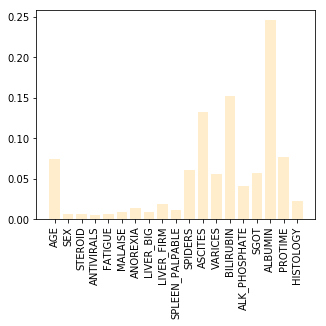

In [38]:
plt.figure(figsize = (5,5))

characteristics_number = list(range(len(patient_characteristics)))
plt.bar(characteristics_number, importance_number, color = 'orange', alpha = 0.2)
plt.xticks(characteristics_number, patient_characteristics, rotation = 90)
plt.gcf().subplots_adjust(bottom=0.3);

In [42]:
#EVALUATION METRICS

accuracy_score(Y_test, y_predicted_grid)*100

80.64516129032258

In [43]:
confusion_matrix(Y_test, y_predicted_grid)

array([[ 2,  5],
       [ 1, 23]], dtype=int64)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_predicted_grid))

              precision    recall  f1-score   support

         0.0       0.67      0.29      0.40         7
         1.0       0.82      0.96      0.88        24

    accuracy                           0.81        31
   macro avg       0.74      0.62      0.64        31
weighted avg       0.79      0.81      0.78        31

